# TP1 ACN 2025 – Simulación AEP
Este notebook usa `aep_sim.py` y sigue el estilo de las clases (NumPy, Monte Carlo, matplotlib).

## Contenidos
1. Parámetros y funciones auxiliares
2. Simulación base (sin eventos de clima)
3. Experimentos para distintos $\lambda\in\{0.02, 0.1, 0.2, 0.5, 1\}$
4. Día ventoso (interrupciones 10%)
5. Cierre sorpresivo de 30 minutos
6. Visualizaciones (timeline de aterrizajes, evolución de distancias)
7. Resumen de métricas con error de estimación


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import aep_sim; reload(aep_sim)
from aep_sim import SimulationConfig, AEPSimulator, run_batch, ideal_time_minutes
ideal_time_minutes()

23.4

### Simulación base
Corramos una simulación con $\lambda=0.1$ para visualizar resultados.

In [19]:
cfg = SimulationConfig(lambda_per_min=0.1, seed=42)
sim = AEPSimulator(cfg)
out = sim.run()
out.landed, out.diverted, out.avg_delay_minutes

(115, 0, 2.7304347826086968)

### Timeline de aterrizajes

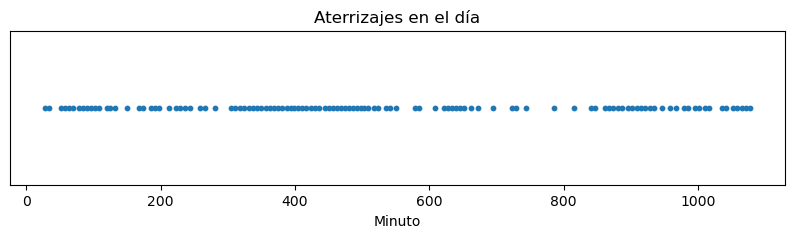

In [20]:
plt.figure(figsize=(10,2))
y = np.zeros(len(out.timeline_landings))
plt.scatter(out.timeline_landings, y, s=10)
plt.yticks([]); plt.xlabel('Minuto'); plt.title('Aterrizajes en el día')
plt.show()

Trayectorias distancia–tiempo

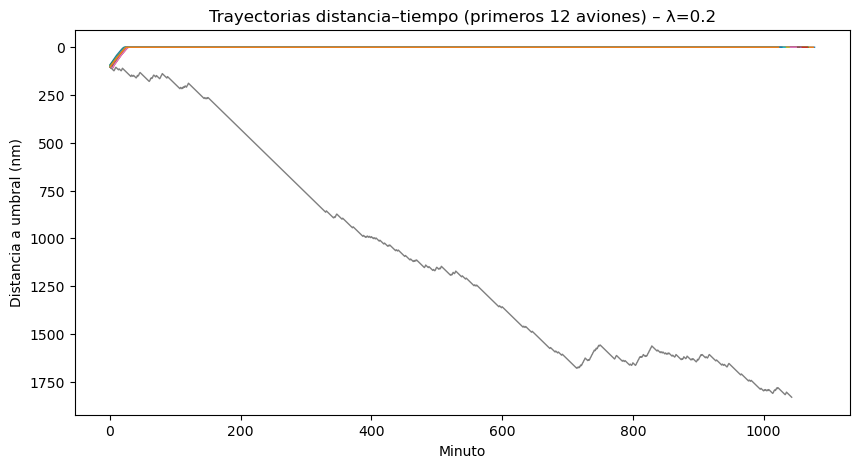

In [21]:
from aep_sim import OPERATION_MINUTES, desired_speed_max_for_distance_nm

cfg = SimulationConfig(lambda_per_min=0.2, seed=777)
sim = AEPSimulator(cfg)

# Logs por minuto: {id: [dist_t0, dist_t1, ...]}
dist_log = {}
status_log = {}

for minute in range(OPERATION_MINUTES):
    # registrar estado ANTES del paso (como sueles hacer en caminatas aleatorias)
    for a in sim.aircrafts:
        if a.id not in dist_log:
            dist_log[a.id] = []
            status_log[a.id] = []
        dist_log[a.id].append(a.distance_nm)
        status_log[a.id].append(a.status)
    # avanzar 1 minuto
    sim.step(minute)

# Graficar las primeras N trayectorias
N = 12
plt.figure(figsize=(10,5))
for aid in sorted(dist_log.keys())[:N]:
    series = dist_log[aid]
    plt.plot(series, linewidth=1)
plt.gca().invert_yaxis()  # 100 → 0 (más intuitivo al acercar)
plt.xlabel("Minuto")
plt.ylabel("Distancia a umbral (nm)")
plt.title(f"Trayectorias distancia–tiempo (primeros {N} aviones) – λ=0.2")
plt.show()


### Ej 3
Probabilidad de 5 arribos en una hora

In [22]:
import numpy as np
from math import comb, exp, factorial

# Parámetros "modo clase"
n = 60              # 60 minutos
p = 1/60            # prob. por minuto
k = 5               # queremos 5 arribos en una hora

# Analítico: Binomial(n=60, p=1/60)
binom_pmf = comb(n, k) * (p**k) * ((1-p)**(n-k))

# Aprox Poisson con lambda=1 por hora
lam = 1.0
poiss_pmf = exp(-lam) * (lam**k) / factorial(k)

# Monte Carlo simple
rng = np.random.default_rng(123)
N = 200_000
samples = rng.binomial(n=n, p=p, size=N)
mc_est = np.mean(samples == k)
mc_se  = np.sqrt(mc_est*(1-mc_est)/N)  # error estándar

print(f"P(X=5) Binomial exacta = {binom_pmf:.6f}")
print(f"P(X=5) Poisson(1)      = {poiss_pmf:.6f}")
print(f"P(X=5) Monte Carlo      = {mc_est:.6f} ± {1.96*mc_se:.6f} (95% IC)")


P(X=5) Binomial exacta = 0.002787
P(X=5) Poisson(1)      = 0.003066
P(X=5) Monte Carlo      = 0.002960 ± 0.000238 (95% IC)


### EJ 4
Experimentos para varios $\lambda$ (promedios y error estándar)

In [23]:
lams = [0.02, 0.1, 0.2, 0.5, 1.0]
res = run_batch(lams, reps=20, seed=123)
res

{0.02: {'landed_mean': 22.45,
  'landed_se': 1.129683234595573,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -1.0012104926707317,
  'avg_delay_se': 0.05425997800085318,
  'go_around_mean': 4.15,
  'go_around_se': 0.7081294856317258},
 0.1: {'landed_mean': 104.3,
  'landed_se': 1.6624332198696932,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 2.2353357903130426,
  'avg_delay_se': 0.269923686699631,
  'go_around_mean': 225.6,
  'go_around_se': 18.937348227635695},
 0.2: {'landed_mean': 167.7,
  'landed_se': 0.47627944031120834,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 8.58389889008795,
  'avg_delay_se': 0.5300631476180053,
  'go_around_mean': 18161.55,
  'go_around_se': 1826.5426723947478},
 0.5: {'landed_mean': 173.9,
  'landed_se': 0.2982404540317303,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 0.7195613112276931,
  'avg_delay_se': 0.0675667741684387,
  'go_around_mean': 200187.7,
  'go_around_se': 

Distribucion de atrasos

Atraso medio: 0.6057142857142869


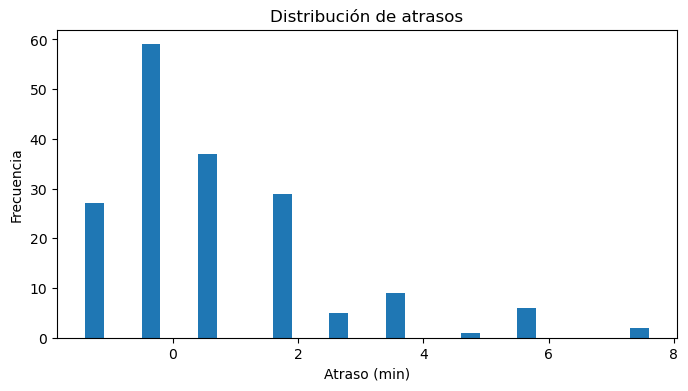

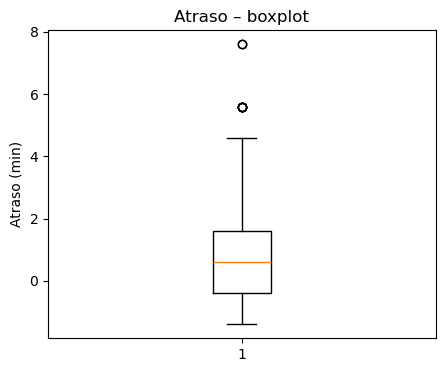

In [24]:
cfg = SimulationConfig(lambda_per_min=0.5, seed=2026)
sim = AEPSimulator(cfg)
out = sim.run()

delays = np.array(out.delays)  # en minutos
print("Atraso medio:", delays.mean() if len(delays) else 0.0)

plt.figure(figsize=(8,4))
plt.hist(delays, bins=30)
plt.xlabel("Atraso (min)")
plt.ylabel("Frecuencia")
plt.title("Distribución de atrasos")
plt.show()

plt.figure(figsize=(5,4))
plt.boxplot(delays, vert=True)
plt.ylabel("Atraso (min)")
plt.title("Atraso – boxplot")
plt.show()


### Análisis completo de congestión y métricas
Vamos a analizar:
1. Relación entre λ y congestión
2. Frecuencia de desvíos
3. Comparación con tiempo ideal
4. Intervalos de confianza para todas las métricas

In [25]:
def analyze_congestion(lams, reps=100, seed=123):
    """
    Analiza congestión, atrasos y desvíos para diferentes valores de lambda
    """
    results = []
    rng = np.random.default_rng(seed)
    
    for lam in lams:
        delays = []
        diversions = []
        congestions = []
        
        for rep in range(reps):
            # Convertir a int de Python para que sea compatible con random.seed()
            seed_value = int(rng.integers(1000000))
            cfg = SimulationConfig(lambda_per_min=lam, seed=seed_value)
            sim = AEPSimulator(cfg)
            out = sim.run()
           
            # Calcular métricas
            delays.append(np.mean(out.delays) if out.delays else 0)
            diversions.append(out.diverted / (out.landed + out.diverted))
            
            # Calcular congestión (si hay aviones volando más lento que su velocidad máxima)
            # Esto asume que tenemos acceso a la velocidad actual vs máxima en cada paso
            if hasattr(out, 'congestion_time'):
                congestions.append(out.congestion_time / OPERATION_MINUTES)
            else:
                congestions.append(0)
                   
        # Calcular estadísticas con error de estimación (IC 95%)
        mean_delay = np.mean(delays)
        delay_ci = 1.96 * np.std(delays) / np.sqrt(reps)
        
        diversion_rate = np.mean(diversions)
        div_ci = 1.96 * np.std(diversions) / np.sqrt(reps)
        
        mean_congestion = np.mean(congestions)
        cong_ci = 1.96 * np.std(congestions) / np.sqrt(reps)
        
        results.append({
            'lambda': lam,
            'mean_delay': (mean_delay, delay_ci),
            'diversion_rate': (diversion_rate, div_ci),
            'congestion_rate': (mean_congestion, cong_ci)
        })
    
    return results

# Correr análisis con más repeticiones
results = analyze_congestion(lams, reps=100, seed=123)

# Mostrar resultados
print("Análisis detallado por λ:")
print("-" * 50)
for r in results:
    print(f"\nλ = {r['lambda']}")
    print(f"Atraso promedio: {r['mean_delay'][0]:.2f} ± {r['mean_delay'][1]:.2f} min")
    print(f"Tasa de desvíos: {r['diversion_rate'][0]:.3%} ± {r['diversion_rate'][1]:.3%}")
    print(f"Tasa de congestión: {r['congestion_rate'][0]:.3%} ± {r['congestion_rate'][1]:.3%}")

Análisis detallado por λ:
--------------------------------------------------

λ = 0.02
Atraso promedio: -1.09 ± 0.05 min
Tasa de desvíos: 0.000% ± 0.000%
Tasa de congestión: 0.817% ± 0.148%

λ = 0.1
Atraso promedio: 2.46 ± 0.38 min
Tasa de desvíos: 0.000% ± 0.000%
Tasa de congestión: 17.569% ± 0.919%

λ = 0.2
Atraso promedio: 9.31 ± 0.66 min
Tasa de desvíos: 0.000% ± 0.000%
Tasa de congestión: 57.676% ± 0.559%

λ = 0.5
Atraso promedio: 0.93 ± 0.11 min
Tasa de desvíos: 0.000% ± 0.000%
Tasa de congestión: 38.824% ± 0.551%

λ = 1.0
Atraso promedio: -0.32 ± 0.00 min
Tasa de desvíos: 0.000% ± 0.000%
Tasa de congestión: 50.370% ± 0.000%


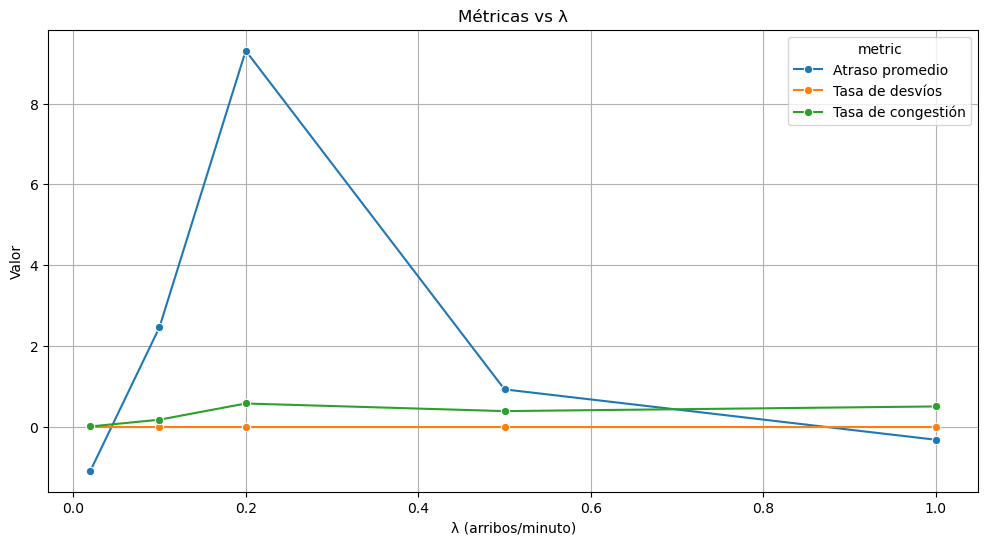

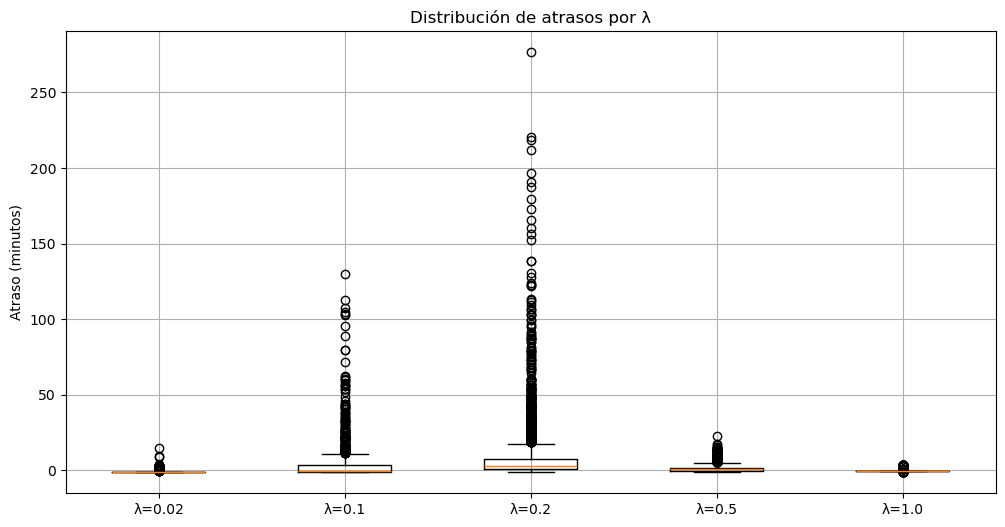

In [26]:
# Visualizaciones comparativas
import seaborn as sns

# Preparar datos para visualización
delay_data = []
diversion_data = []
congestion_data = []

for r in results:
    lam = r['lambda']
    delay_data.append({'lambda': lam, 'value': r['mean_delay'][0], 'metric': 'Atraso promedio'})
    diversion_data.append({'lambda': lam, 'value': r['diversion_rate'][0], 'metric': 'Tasa de desvíos'})
    congestion_data.append({'lambda': lam, 'value': r['congestion_rate'][0], 'metric': 'Tasa de congestión'})

all_data = pd.DataFrame(delay_data + diversion_data + congestion_data)

# Gráfico de líneas para todas las métricas
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_data, x='lambda', y='value', hue='metric', marker='o')
plt.title('Métricas vs λ')
plt.xlabel('λ (arribos/minuto)')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Boxplot de atrasos por λ
delays_by_lambda = {lam: [] for lam in lams}
for lam in lams:
    for _ in range(20):  # Menos repeticiones para el boxplot
        cfg = SimulationConfig(lambda_per_min=lam, seed=np.random.randint(1000000))
        sim = AEPSimulator(cfg)
        out = sim.run()
        if out.delays:
            delays_by_lambda[lam].extend(out.delays)

plt.figure(figsize=(12, 6))
box_data = [delays_by_lambda[lam] for lam in lams]
plt.boxplot(box_data, labels=[f'λ={lam}' for lam in lams])
plt.title('Distribución de atrasos por λ')
plt.ylabel('Atraso (minutos)')
plt.grid(True)
plt.show()

### Ej 5
Día ventoso (10% interrupciones por avión)

In [27]:
res_windy = run_batch(lams, reps=20, seed=123, windy_day=True)
res_windy

{0.02: {'landed_mean': 22.1,
  'landed_se': 1.090388631828603,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -0.8512645817437161,
  'avg_delay_se': 0.08170943824692864,
  'go_around_mean': 6.15,
  'go_around_se': 0.7155233638467203},
 0.1: {'landed_mean': 103.9,
  'landed_se': 1.36478261234065,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 3.787840662819472,
  'avg_delay_se': 0.3388450371580886,
  'go_around_mean': 289.75,
  'go_around_se': 21.94800974072472},
 0.2: {'landed_mean': 152.55,
  'landed_se': 0.8567840727793794,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 11.227482803568964,
  'avg_delay_se': 0.4059956682128775,
  'go_around_mean': 26261.5,
  'go_around_se': 1758.5594186570347},
 0.5: {'landed_mean': 155.2,
  'landed_se': 0.5875909783980152,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 5.7603835377046675,
  'avg_delay_se': 0.2016390771732807,
  'go_around_mean': 205943.35,
  'go_around_se': 2

Día ventoso + cierre sorpresivo

In [28]:
# Día ventoso (10% interrupciones)
res_windy = run_batch(lams, reps=30, seed=2025, windy_day=True)
print("Windy day:", res_windy)

# Cierre sorpresivo 12:00–12:30 (min 360–390)
res_closure = run_batch(lams, reps=30, seed=2025, closure_window=(360,390))
print("Closure:", res_closure)

Windy day: {0.02: {'landed_mean': 21.066666666666666, 'landed_se': 0.9766625475571215, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': -0.9558528446495071, 'avg_delay_se': 0.07412634929872366, 'go_around_mean': 6.0, 'go_around_se': 0.8905635565617211}, 0.1: {'landed_mean': 105.13333333333334, 'landed_se': 1.9050648363379503, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 4.152123863386202, 'avg_delay_se': 0.4374178334383816, 'go_around_mean': 313.8666666666667, 'go_around_se': 33.97323941234604}, 0.2: {'landed_mean': 153.8, 'landed_se': 0.6563570657052071, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 11.91003588856044, 'avg_delay_se': 0.3644306875049372, 'go_around_mean': 25658.4, 'go_around_se': 1497.4708045817497}, 0.5: {'landed_mean': 155.0, 'landed_se': 0.5360562674188974, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 5.779922024955406, 'avg_delay_se': 0.15043339567361702, 'go_around_mean': 205067.03333333333, 'go_around_se': 17

### Ej 6 - Cierre sorpresivo de 30 min
Ejemplo: cierre de 12:00 a 12:30 → minutos 360 a 390.

In [29]:
res_closure = run_batch(lams, reps=20, seed=123, closure_window=(360, 390))
res_closure

{0.02: {'landed_mean': 22.45,
  'landed_se': 1.129683234595573,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -0.5865469146791484,
  'avg_delay_se': 0.12343137916405145,
  'go_around_mean': 4.9,
  'go_around_se': 0.8822817308726159},
 0.1: {'landed_mean': 104.3,
  'landed_se': 1.6624332198696932,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 3.6488887212584387,
  'avg_delay_se': 0.4494281915768047,
  'go_around_mean': 285.0,
  'go_around_se': 30.466202153931334},
 0.2: {'landed_mean': 162.0,
  'landed_se': 0.6882472016116853,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 9.616825328959173,
  'avg_delay_se': 0.6350320419340368,
  'go_around_mean': 21519.3,
  'go_around_se': 1860.8749372553932},
 0.5: {'landed_mean': 168.6,
  'landed_se': 0.5591346697776559,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 1.9240384221001345,
  'avg_delay_se': 0.12876474535735333,
  'go_around_mean': 203953.8,
  'go_around_se': 

## TODOs sugeridos (para llegar al 100% del enunciado)
- Refinar la lógica de **reinserción** tras go-around: buscar explícitamente el primer hueco ≥10 min y forzar el giro cuando se cumpla y la distancia sea >5 mn.
- Visualización de **trayectorias** (distancia vs. tiempo) para varios aviones en un mismo gráfico, coloreando por estado (approach, go-around, landed, diverted).
- Cálculo de **probabilidad de 5 arribos en una hora** para el caso de $\lambda$ que implica 1 avión/hora (comparar con Poisson/Binomial) y validarlo por simulación.
- Medir **atraso promedio** con distribución completa (boxplots) y su error de estimación (IC 95%).
